In [ ]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import struct 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
def create_weight_matrix(nrows, ncols, init_type='normal'):
    if init_type == 'normal':
        return np.random.default_rng().normal(loc=0, scale=1, size=(nrows, ncols))
    elif init_type == 'zero':
        return np.zeros((nrows, ncols))
    elif init_type == 'random':
        return np.random.default_rng().uniform(-1, 1, size=(nrows, ncols))
    else:
        raise ValueError("Unknown initialization type")

def create_bias_vector(length):
    return create_weight_matrix(length, 1) 

class ActivationFunction(ABC):
    @abstractmethod
    def f(self, x):
        pass
    @abstractmethod
    def df(self, x):
        pass
class ReLU(ActivationFunction):
    def f(self, x):
        return np.maximum(0, x)

    def df(self, x):
        return np.where(x > 0, 1, 0)
class LeakyReLU(ActivationFunction):
    def __init__(self, leaky_param=0.1):
        self.alpha = leaky_param

    def f(self, x):
        return np.maximum(x, x * self.alpha)

    def df(self, x):
        return np.where(x > 0, 1, self.alpha)
class Softmax(ActivationFunction):
    def f(self, x):
        e_x = np.exp(x- np.max(x, axis=0, keepdims=True) ) 
        return e_x / e_x.sum(axis=0, keepdims=True)

    def df(self, x):
        p = self.f(x)
        return p * (1 - p)
class Sigmoid(ActivationFunction):
    def f(self, x):
        return 1 / (1 + np.exp(-x))

    def df(self, x):
        sig = self.f(x)
        return sig * (1 - sig)
class Tanh(ActivationFunction):
    def f(self, x):
        return np.tanh(x)

    def df(self, x):
        return 1 - np.tanh(x)**2
    
class Layer:
    def __init__(self, ins, outs, act_function, init_type='normal'):
        self.ins = ins
        self.outs = outs
        self.act_function = act_function

        self._W = create_weight_matrix(self.outs, self.ins, init_type)
        self._b = create_bias_vector(self.outs)

    def forward_pass(self, x):
        self.last_z = np.dot(self._W, x) + self._b
        self.last_a = self.act_function.f(self.last_z)
        return self.last_a

    def backward_pass(self, dA, x, learning_rate):
        dZ = dA * self.act_function.df(self.last_z)
        dW = np.dot(dZ, x.T) / x.shape[1]
        db = np.sum(dZ, axis=1, keepdims=True) / x.shape[1]
        dA_prev = np.dot(self._W.T, dZ)
        self._W -= learning_rate * dW
        self._b -= learning_rate * db
        return dA_prev

class LossFunction(ABC):
    @abstractmethod
    def loss(self, values, expected):
        pass

    @abstractmethod
    def dloss(self, values, expected):
        pass

class LogLoss(LossFunction):
    def loss(self, values, expected):
        return -np.mean(expected * np.log(values) )
    def dloss(self, values, expected):
        return -(expected - values)
    
class CrossEntropyLoss(LossFunction):
    def loss(self, values, expected):
        values_for_answers = values[np.arange(len(values)), expected.argmax(axis=1)]
        # Compute cross-entropy loss
        xentropy = -values_for_answers + np.log(np.sum(np.exp(values), axis=1))
        return np.mean(xentropy)

    def dloss(self, values, expected):
        softmax = np.exp(values) / np.exp(values).sum(axis=1, keepdims=True)
        return (softmax - expected) / values.shape[0] 

class NeuralNetwork:
    def __init__(self, layers, loss_function, learning_rate):
        self._layers = layers
        self._loss_function = loss_function
        self.lr = learning_rate
        for (from_, to_) in zip(self._layers[:-1], self._layers[1:]):
            if from_.outs != to_.ins:
                raise ValueError("Layers should have compatible shapes.")

    def forward_pass(self, x):
        out = x
        for layer in self._layers:
            out = layer.forward_pass(out)
        return out

    def loss(self, values, expected):
        return self._loss_function.loss(values, expected)

    def train(self, x, t):
        activations = [x]
        for layer in self._layers:
            activations.append(layer.forward_pass(activations[-1]))
        dx = self._loss_function.dloss(activations[-1], t)
        for layer, a in zip(self._layers[::-1], activations[:-1][::-1]):
            dx = layer.backward_pass(dx, a, self.lr)

    def predict(self, x):
        output = self.forward_pass(x)
        return np.argmax(output, axis=0)

    def predict_proba(self, x):
        return self.forward_pass(x)

    def accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

def load_idx(filepath):
    with open(filepath, 'rb') as f:
        magic, num_items = struct.unpack(">II", f.read(8))
        if magic == 2051: 
            rows, cols = struct.unpack(">II", f.read(8))
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_items, rows * cols)
            return images / 255.0  
        elif magic == 2049:  
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels

X_train = load_idx("data/train-images.idx3-ubyte")
y_train = load_idx("data/train-labels.idx1-ubyte")
X_test = load_idx("data/t10k-images.idx3-ubyte")
y_test = load_idx("data/t10k-labels.idx1-ubyte")
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train.reshape(-1, 1)).T
y_test = enc.transform(y_test.reshape(-1, 1)).T
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test.T, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train, y_test.T
X_val, y_val = X_val.T, y_val.T
print(X_train[0])


(60000, 784)
(5000, 784)
(10, 60000)
(5000, 10)
[0. 0. 0. ... 0. 0. 0.]



Training with Sigmoid activation and random initialization
Epoch 1/100
Train Loss: 0.2223, Validation Loss: 0.2222
Epoch 2/100
Train Loss: 0.2018, Validation Loss: 0.2018
Epoch 3/100
Train Loss: 0.1783, Validation Loss: 0.1779
Epoch 4/100
Train Loss: 0.1597, Validation Loss: 0.1588
Epoch 5/100
Train Loss: 0.1443, Validation Loss: 0.1430
Epoch 6/100
Train Loss: 0.1318, Validation Loss: 0.1303
Epoch 7/100
Train Loss: 0.1219, Validation Loss: 0.1203
Epoch 8/100
Train Loss: 0.1149, Validation Loss: 0.1134
Epoch 9/100
Train Loss: 0.1095, Validation Loss: 0.1082
Epoch 10/100
Train Loss: 0.1050, Validation Loss: 0.1039
Epoch 11/100
Train Loss: 0.1011, Validation Loss: 0.1002
Epoch 12/100
Train Loss: 0.0975, Validation Loss: 0.0969
Epoch 13/100
Train Loss: 0.0942, Validation Loss: 0.0938
Epoch 14/100
Train Loss: 0.0913, Validation Loss: 0.0911
Epoch 15/100
Train Loss: 0.0884, Validation Loss: 0.0885
Epoch 16/100
Train Loss: 0.0857, Validation Loss: 0.0859
Epoch 17/100
Train Loss: 0.0832, Vali

C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 2/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 3/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 4/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 5/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 6/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 7/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 8/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 9/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 10/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 11/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 12/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 13/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 14/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 15/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 16/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 17/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 18/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 19/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 20/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 21/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 22/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 23/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 24/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 25/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 26/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 27/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 28/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 29/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 30/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 31/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 32/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 33/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 34/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 35/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 36/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 37/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 38/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 39/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 40/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 41/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 42/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 43/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 44/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 45/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 46/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 47/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 48/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 49/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 50/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 51/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 52/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 53/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 54/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 55/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 56/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 57/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 58/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 59/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 60/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 61/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 62/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 63/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 64/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 65/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 66/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 67/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 68/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 69/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 70/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 71/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 72/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 73/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 74/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 75/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 76/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 77/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 78/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 79/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 80/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 81/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 82/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 83/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 84/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 85/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 86/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 87/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 88/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 89/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 90/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 91/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 92/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 93/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 94/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 95/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 96/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 97/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 98/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 99/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 100/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan

Training with ReLU activation and normal initialization
Epoch 1/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 2/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 3/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 4/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 5/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 6/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 7/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 8/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 9/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 10/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 11/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 12/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 13/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 14/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 15/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 16/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 17/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 18/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 19/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 20/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 21/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 22/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 23/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 24/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 25/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 26/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 27/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 28/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 29/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 30/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 31/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 32/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 33/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 34/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 35/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 36/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 37/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 38/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 39/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 40/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 41/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 42/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 43/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 44/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 45/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 46/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 47/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 48/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 49/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 50/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 51/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 52/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 53/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 54/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 55/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 56/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 57/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 58/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 59/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 60/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 61/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 62/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 63/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 64/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 65/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 66/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 67/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 68/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 69/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 70/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 71/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 72/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 73/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 74/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 75/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 76/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 77/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 78/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 79/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 80/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 81/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 82/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 83/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 84/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 85/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 86/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 87/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 88/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 89/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 90/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 91/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 92/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 93/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 94/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 95/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 96/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 97/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 98/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 99/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 100/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan

Training with ReLU activation and zero initialization
Epoch 1/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 2/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 3/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 4/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 5/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 6/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 7/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 8/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 9/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 10/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 11/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 12/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 13/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 14/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 15/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoch 16/100
Train Loss: 0.2302, Validation Loss: 0.2301
Epoc

C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 2/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 3/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 4/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 5/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 6/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 7/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 8/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 9/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 10/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 11/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 12/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 13/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 14/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 15/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 16/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 17/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 18/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 19/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 20/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 21/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 22/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 23/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 24/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 25/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 26/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 27/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 28/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 29/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 30/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 31/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 32/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 33/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 34/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 35/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 36/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 37/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 38/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 39/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 40/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 41/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 42/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 43/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 44/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 45/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 46/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 47/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 48/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 49/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 50/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 51/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 52/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 53/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 54/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 55/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 56/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 57/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 58/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 59/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 60/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 61/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 62/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 63/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 64/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 65/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 66/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 67/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 68/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 69/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 70/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 71/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 72/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 73/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 74/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 75/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 76/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 77/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 78/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 79/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 80/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 81/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 82/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 83/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 84/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 85/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 86/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 87/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 88/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 89/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 90/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 91/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 92/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 93/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 94/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 95/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 96/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 97/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 98/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 99/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 100/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan

Training with LeakyReLU activation and normal initialization
Epoch 1/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 2/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 3/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 4/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 5/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 6/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 7/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 8/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 9/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 10/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 11/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 12/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 13/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 14/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 15/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 16/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 17/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 18/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 19/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 20/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 21/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 22/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 23/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 24/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 25/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 26/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 27/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 28/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 29/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 30/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 31/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 32/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 33/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 34/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 35/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 36/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 37/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 38/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 39/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 40/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 41/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 42/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 43/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 44/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 45/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 46/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 47/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 48/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 49/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 50/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 51/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 52/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 53/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 54/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 55/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 56/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 57/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 58/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 59/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 60/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 61/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 62/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 63/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 64/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 65/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 66/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 67/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 68/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 69/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 70/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 71/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 72/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 73/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 74/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 75/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 76/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 77/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 78/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 79/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 80/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 81/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 82/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 83/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 84/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 85/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 86/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 87/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 88/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 89/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 90/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 91/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 92/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 93/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 94/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 95/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 96/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 97/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 98/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 99/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan
Epoch 100/100


C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: divide by zero encountered in log
  return -np.mean(expected * np.log(values) )
C:\Users\halog\AppData\Local\Temp\ipykernel_26440\3525723386.py:113: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(expected * np.log(values) )


Train Loss: nan, Validation Loss: nan

Training with LeakyReLU activation and zero initialization
Epoch 1/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 2/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 3/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 4/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 5/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 6/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 7/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 8/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 9/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 10/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 11/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 12/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 13/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 14/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 15/100
Train Loss: 0.2301, Validation Loss: 0.2301
Epoch 16/100
Train Loss: 0.2301, Validation Loss: 0.2301

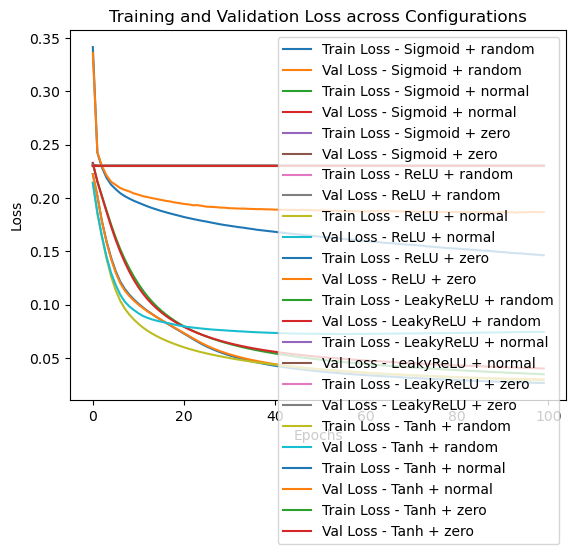

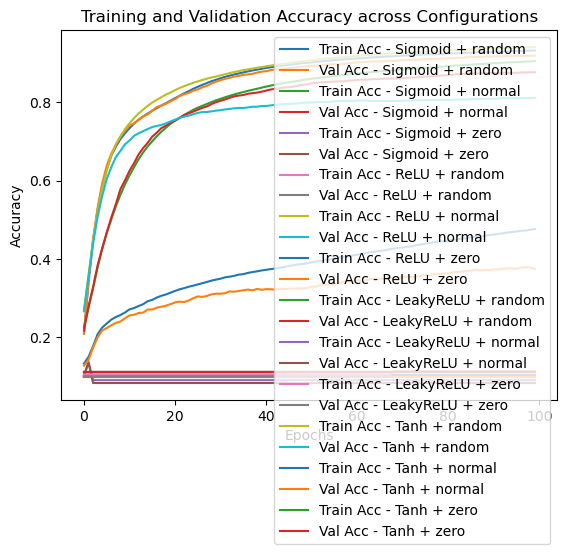

Activation: Sigmoid, Initialization: random
Final Train Loss: 0.0267, Final Val Loss: 0.0301
Final Train Accuracy: 93.25%, Final Val Accuracy: 91.94%

Activation: Sigmoid, Initialization: normal
Final Train Loss: 0.0349, Final Val Loss: 0.0403
Final Train Accuracy: 90.53%, Final Val Accuracy: 87.68%

Activation: Sigmoid, Initialization: zero
Final Train Loss: 0.2301, Final Val Loss: 0.2301
Final Train Accuracy: 11.24%, Final Val Accuracy: 11.22%

Activation: ReLU, Initialization: random
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 10.22%, Final Val Accuracy: 10.46%

Activation: ReLU, Initialization: normal
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 9.87%, Final Val Accuracy: 9.88%

Activation: ReLU, Initialization: zero
Final Train Loss: 0.2301, Final Val Loss: 0.2301
Final Train Accuracy: 10.44%, Final Val Accuracy: 9.92%

Activation: LeakyReLU, Initialization: random
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 11.24%, Fin

In [ ]:

activations = ['Sigmoid', 'ReLU', 'LeakyReLU', 'Tanh']
initializations = ['random', 'normal', 'zero']
models = []
results = []

for activation_name in activations:
    for init_type in initializations:
        print(f"\nTraining with {activation_name} activation and {init_type} initialization")

        if activation_name == 'Sigmoid':
            activation = Sigmoid()
        elif activation_name == 'ReLU':
            activation = ReLU()
        elif activation_name == 'LeakyReLU':
            activation = LeakyReLU()
        elif activation_name == 'Tanh':
            activation = Tanh()

        net = NeuralNetwork([
            Layer(784, 256, activation, init_type=init_type),
            Layer(256, 128, activation, init_type=init_type),
            Layer(128, 64, activation, init_type=init_type),
            Layer(64, 32, activation, init_type=init_type),
            Layer(32, 10, Softmax(), init_type=init_type)
        ], LogLoss(), 0.1)

        epochs = 100
        batch_size = 128
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")

            for i in range(0, X_train.shape[1], batch_size):
                x_batch = X_train[:, i:i+batch_size]
                t_batch = y_train[:, i:i+batch_size]
                net.train(x_batch, t_batch)

            train_loss = net.loss(net.forward_pass(X_train), y_train)
            val_loss = net.loss(net.forward_pass(X_val), y_val)
            train_acc = net.accuracy(np.argmax(y_train, axis=0), net.predict(X_train))
            val_acc = net.accuracy(np.argmax(y_val, axis=0), net.predict(X_val))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        model_filename = f"model_{activation_name}_{init_type}.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(net, f)

        results.append({
            'activation': activation_name,
            'initialization': init_type,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        })
        models.append(net)

for result in results:
    plt.plot(range(epochs), result['train_losses'], label=f"Train Loss - {result['activation']} + {result['initialization']}")
    plt.plot(range(epochs), result['val_losses'], label=f"Val Loss - {result['activation']} + {result['initialization']}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss across Configurations")
plt.show()

for result in results:
    plt.plot(range(epochs), result['train_accuracies'], label=f"Train Acc - {result['activation']} + {result['initialization']}")
    plt.plot(range(epochs), result['val_accuracies'], label=f"Val Acc - {result['activation']} + {result['initialization']}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy across Configurations")
plt.show()

for result in results:
    print(f"Activation: {result['activation']}, Initialization: {result['initialization']}")
    print(f"Final Train Loss: {result['train_losses'][-1]:.4f}, Final Val Loss: {result['val_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {result['train_accuracies'][-1] * 100:.2f}%, Final Val Accuracy: {result['val_accuracies'][-1] * 100:.2f}%\n")




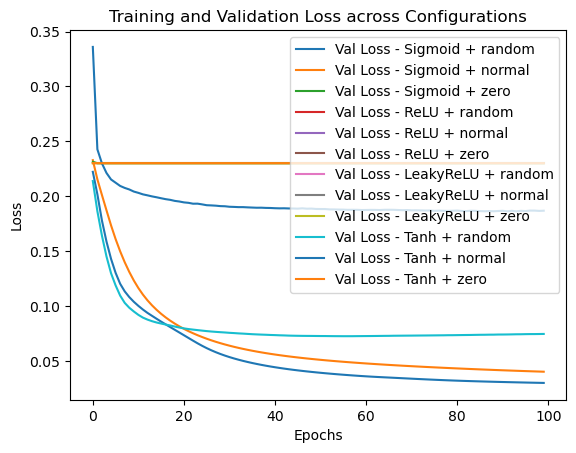

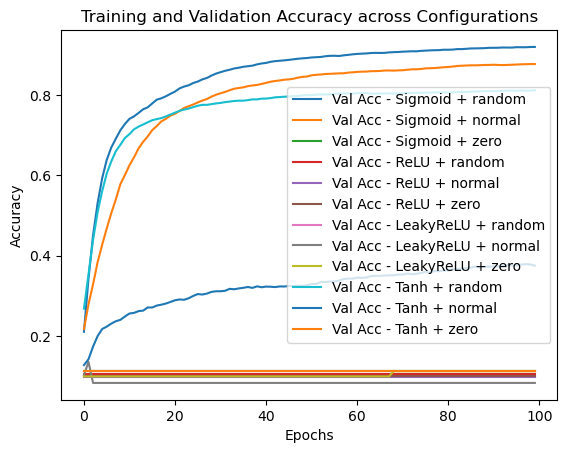

Activation: Sigmoid, Initialization: random
Final Train Loss: 0.0267, Final Val Loss: 0.0301
Final Train Accuracy: 93.25%, Final Val Accuracy: 91.94%

Activation: Sigmoid, Initialization: normal
Final Train Loss: 0.0349, Final Val Loss: 0.0403
Final Train Accuracy: 90.53%, Final Val Accuracy: 87.68%

Activation: Sigmoid, Initialization: zero
Final Train Loss: 0.2301, Final Val Loss: 0.2301
Final Train Accuracy: 11.24%, Final Val Accuracy: 11.22%

Activation: ReLU, Initialization: random
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 10.22%, Final Val Accuracy: 10.46%

Activation: ReLU, Initialization: normal
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 9.87%, Final Val Accuracy: 9.88%

Activation: ReLU, Initialization: zero
Final Train Loss: 0.2301, Final Val Loss: 0.2301
Final Train Accuracy: 10.44%, Final Val Accuracy: 9.92%

Activation: LeakyReLU, Initialization: random
Final Train Loss: nan, Final Val Loss: nan
Final Train Accuracy: 11.24%, Fin

In [ ]:
for result in results:
    plt.plot(range(epochs), result['val_losses'], label=f"Val Loss - {result['activation']} + {result['initialization']}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss across Configurations")
plt.show()

for result in results:
    plt.plot(range(epochs), result['val_accuracies'], label=f"Val Acc - {result['activation']} + {result['initialization']}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy across Configurations")
plt.show()

for result in results:
    print(f"Activation: {result['activation']}, Initialization: {result['initialization']}")
    print(f"Final Train Loss: {result['train_losses'][-1]:.4f}, Final Val Loss: {result['val_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {result['train_accuracies'][-1] * 100:.2f}%, Final Val Accuracy: {result['val_accuracies'][-1] * 100:.2f}%\n")

Train Accuracy: 93.25%


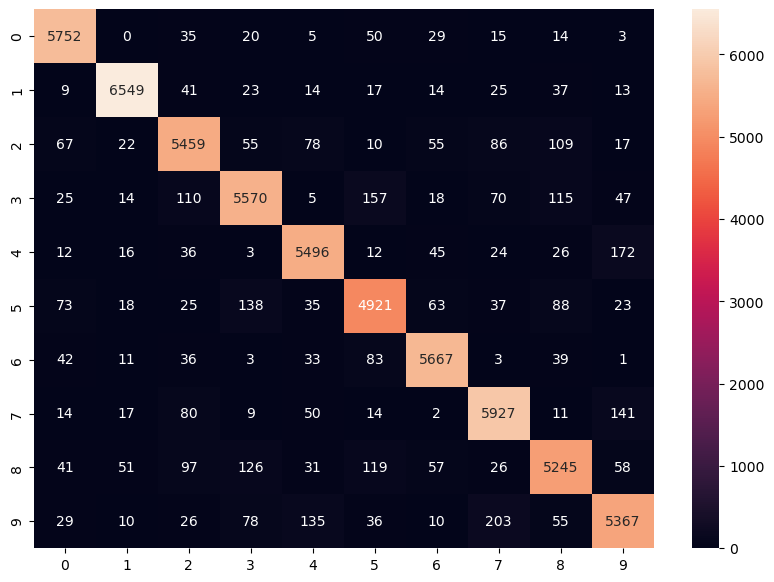

Train Accuracy: 90.53%


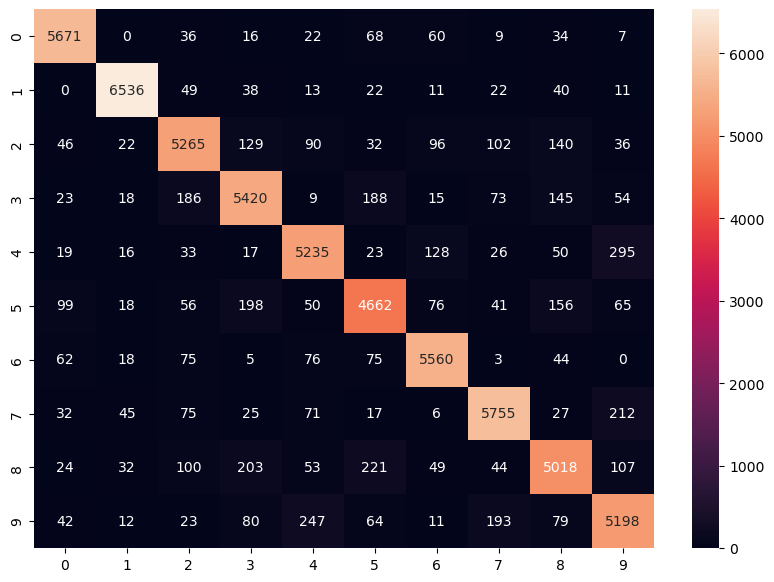

Train Accuracy: 11.24%


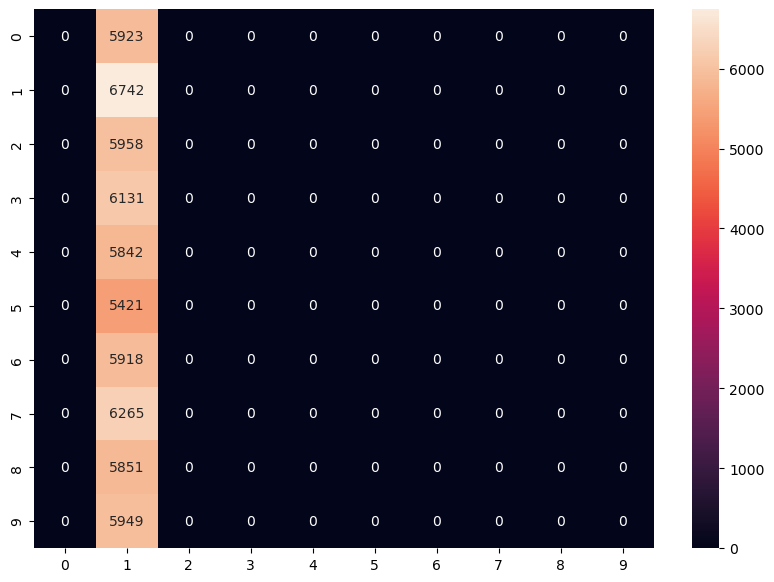

Train Accuracy: 10.22%


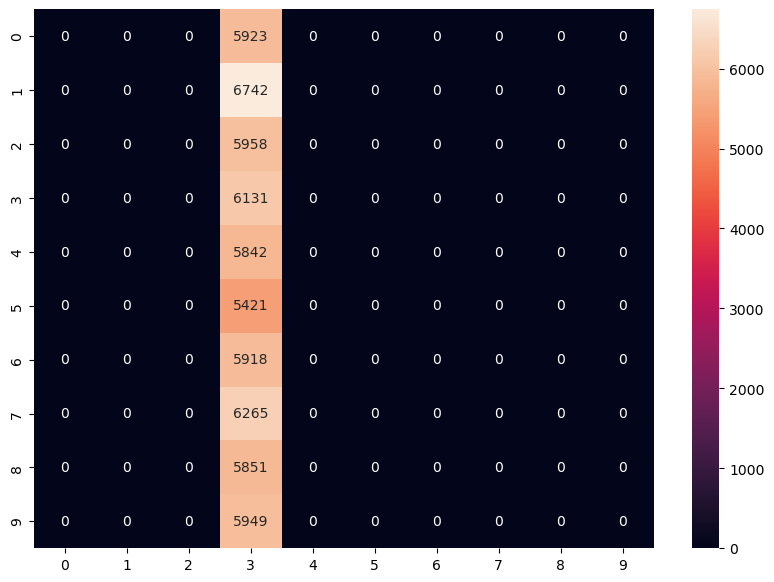

Train Accuracy: 9.87%


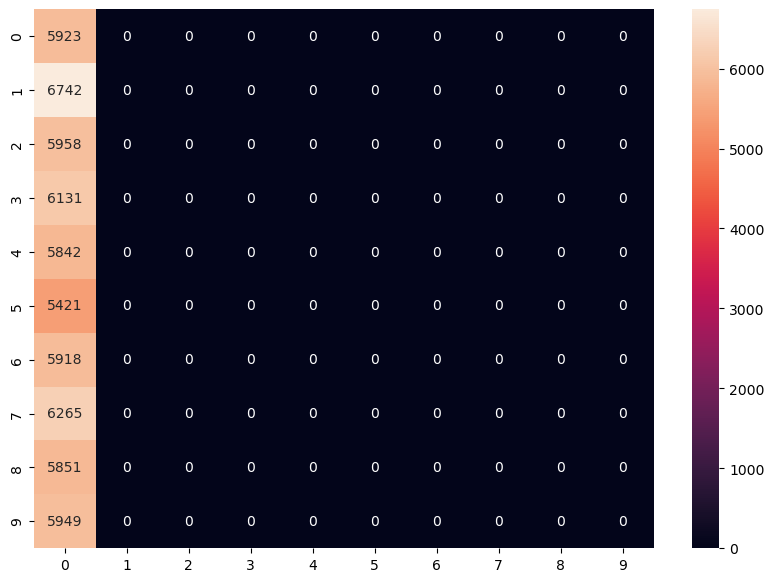

Train Accuracy: 10.44%


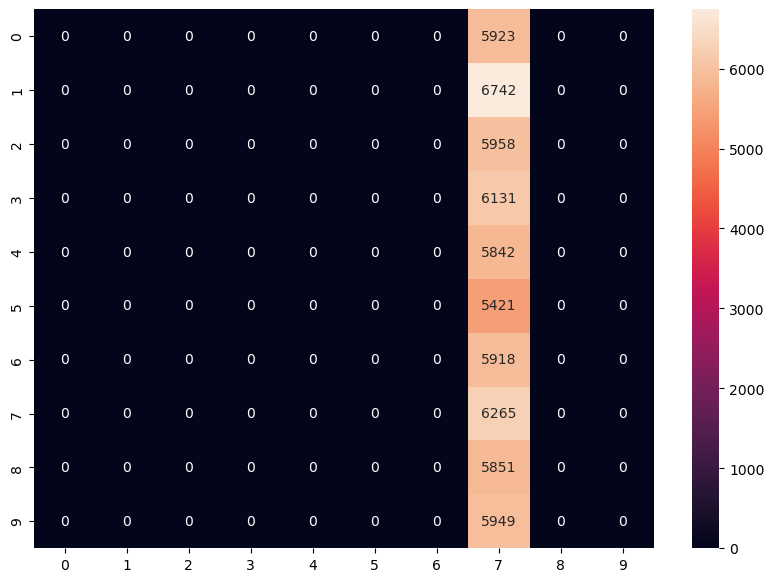

Train Accuracy: 11.24%


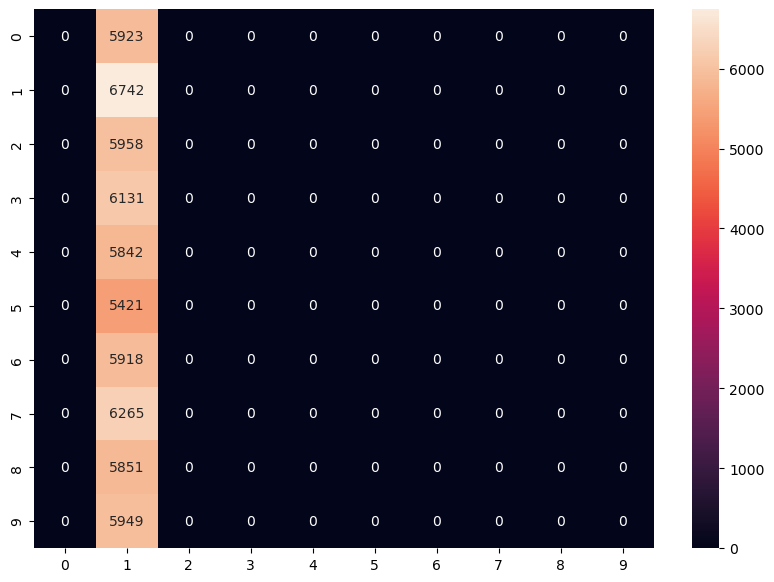

Train Accuracy: 9.04%


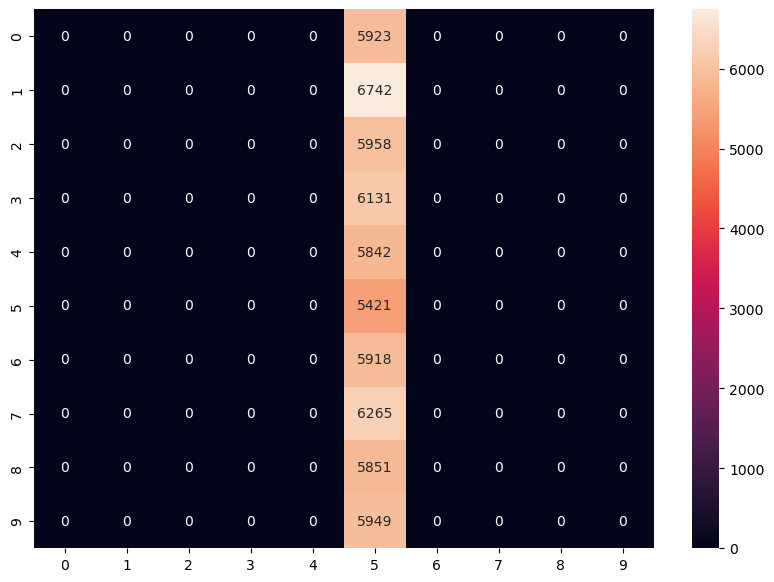

Train Accuracy: 11.24%


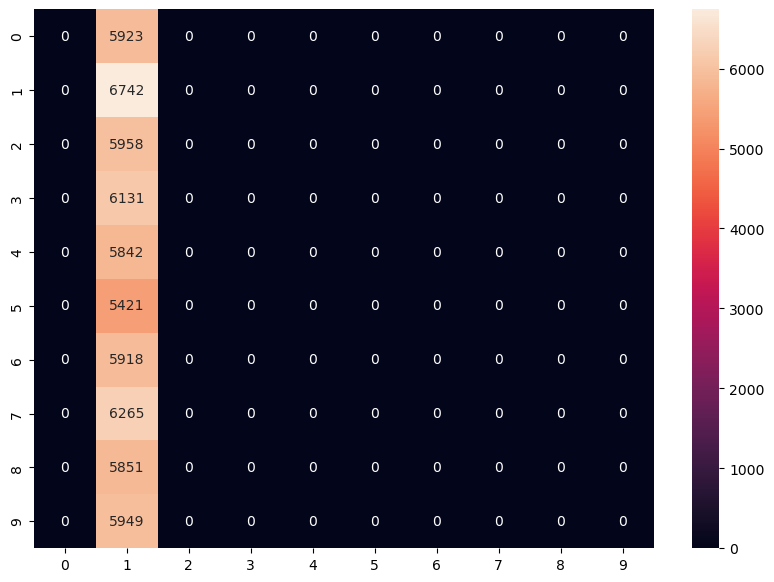

Train Accuracy: 94.13%


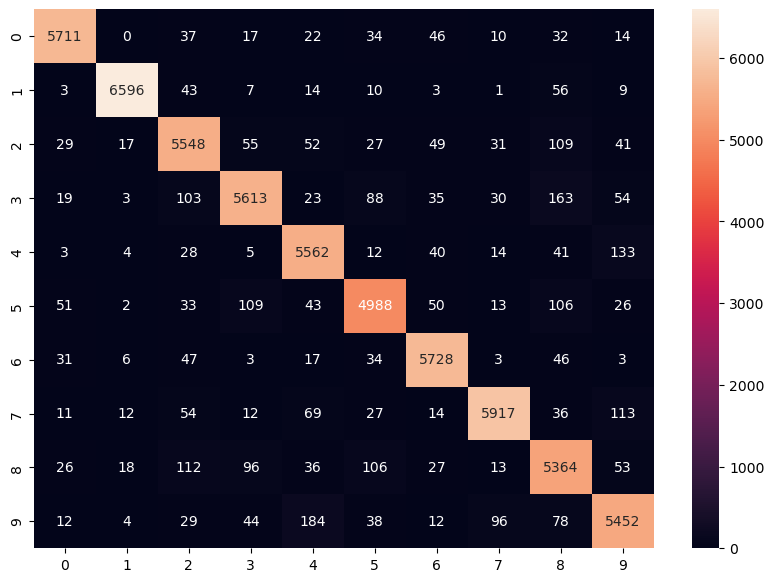

Train Accuracy: 47.65%


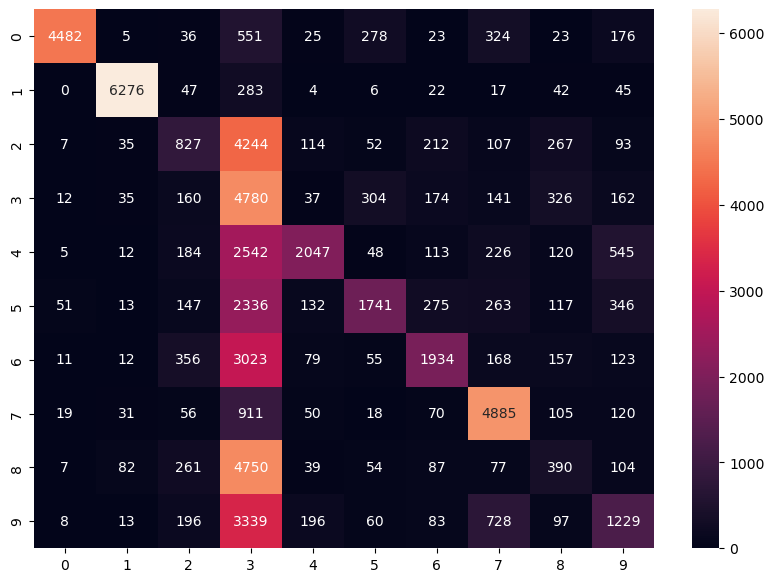

Train Accuracy: 11.24%


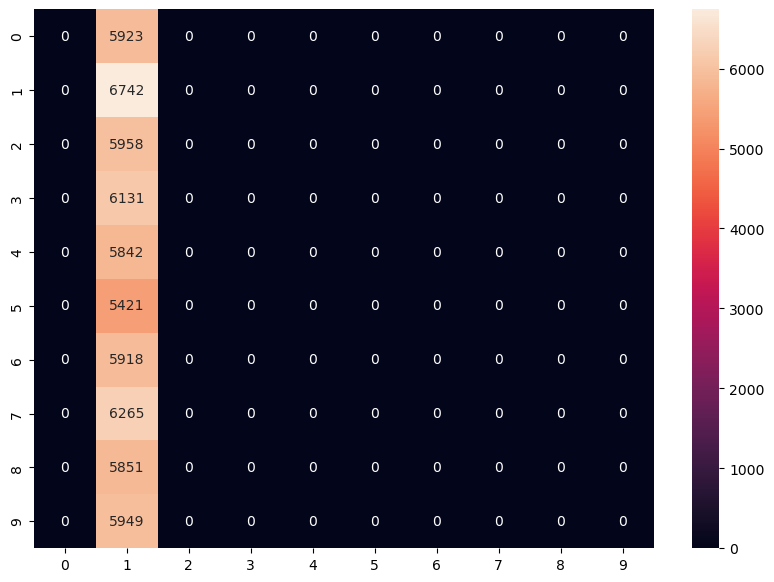

Test Accuracy: 92.70%


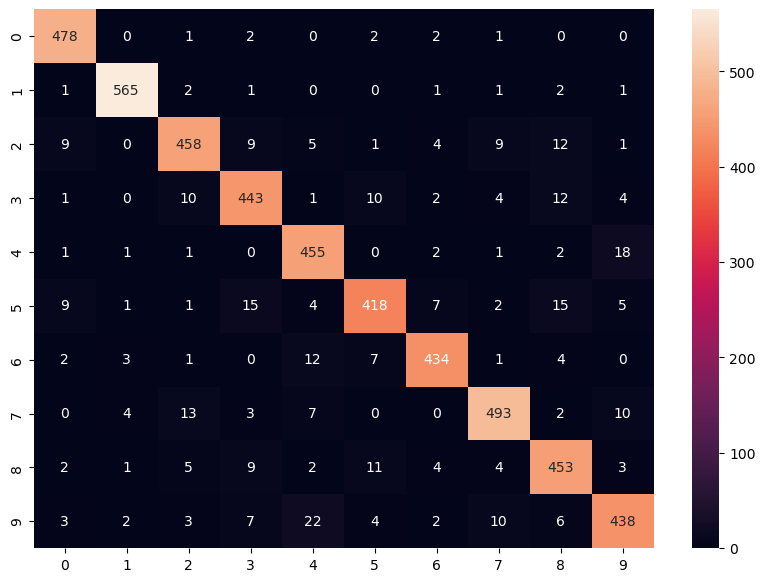

Test Accuracy: 87.52%


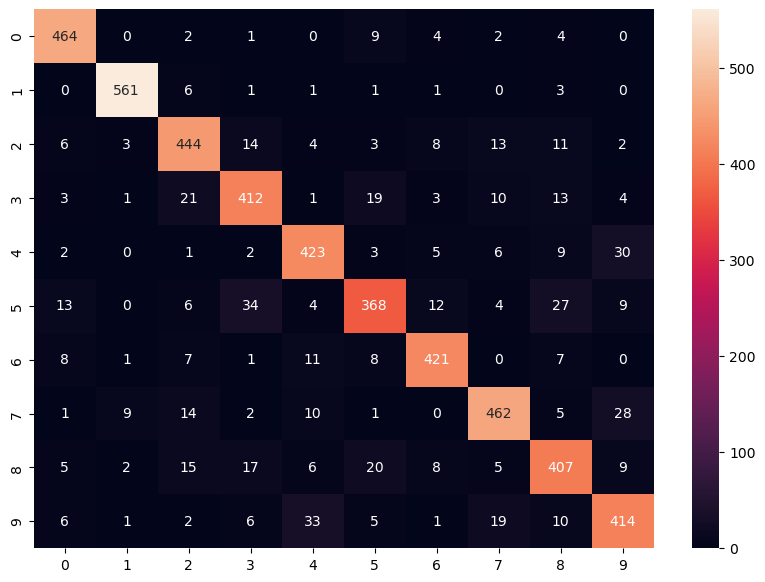

Test Accuracy: 11.48%


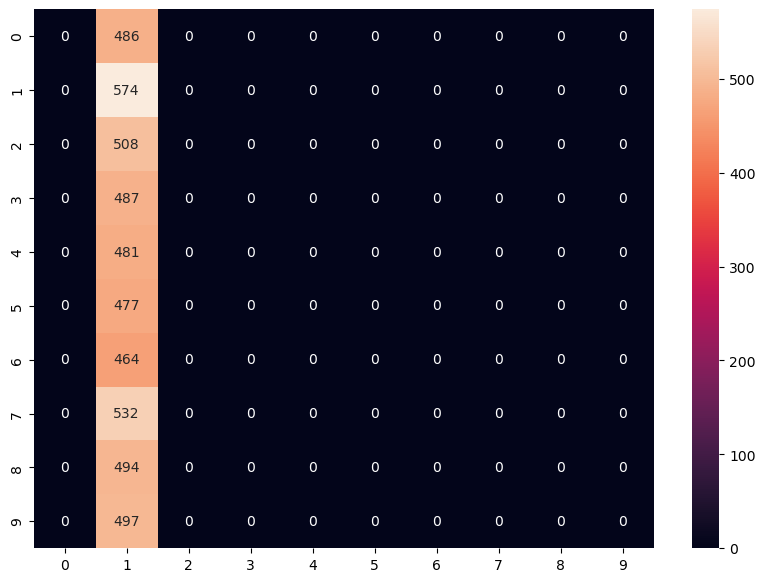

Test Accuracy: 9.74%


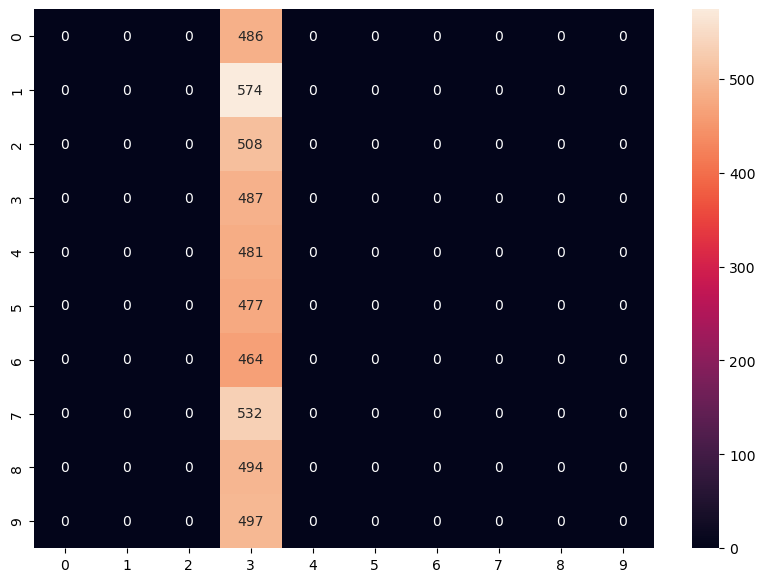

Test Accuracy: 9.72%


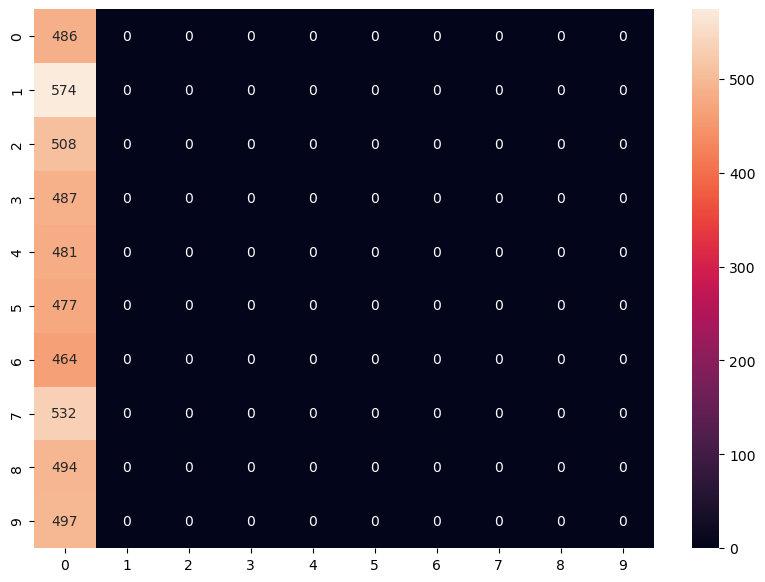

Test Accuracy: 10.64%


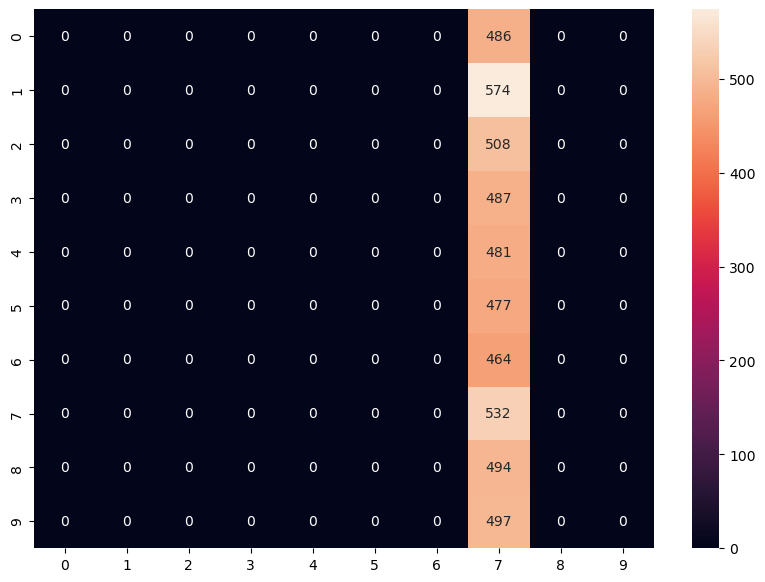

Test Accuracy: 11.48%


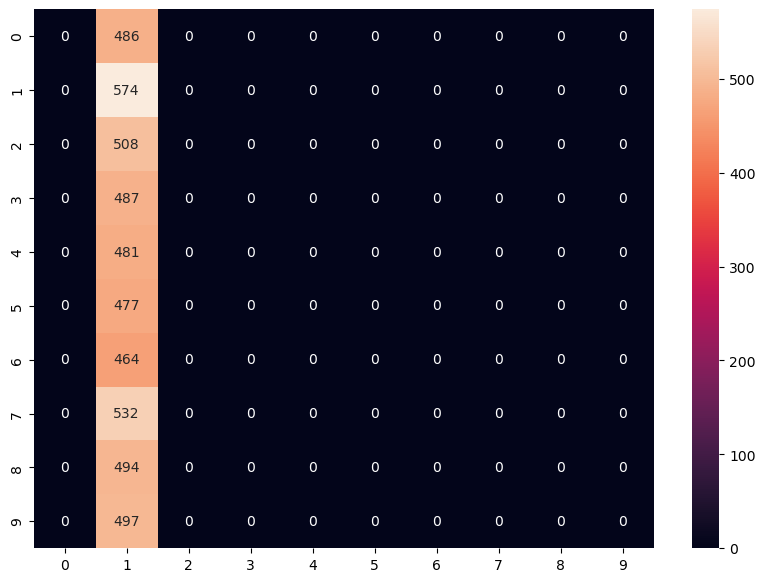

Test Accuracy: 9.54%


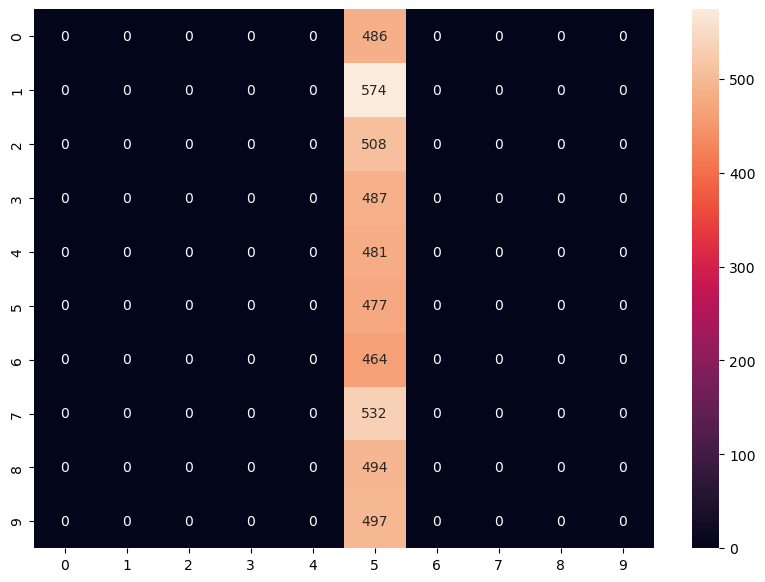

Test Accuracy: 11.48%


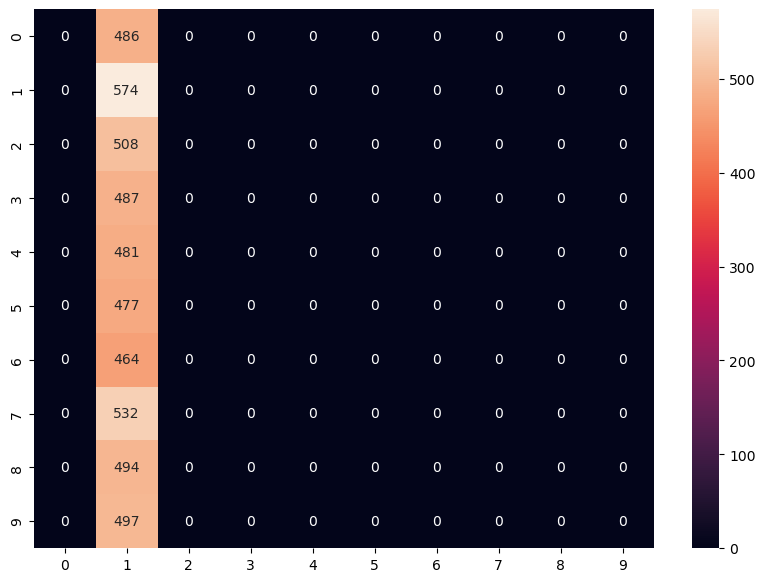

Test Accuracy: 81.36%


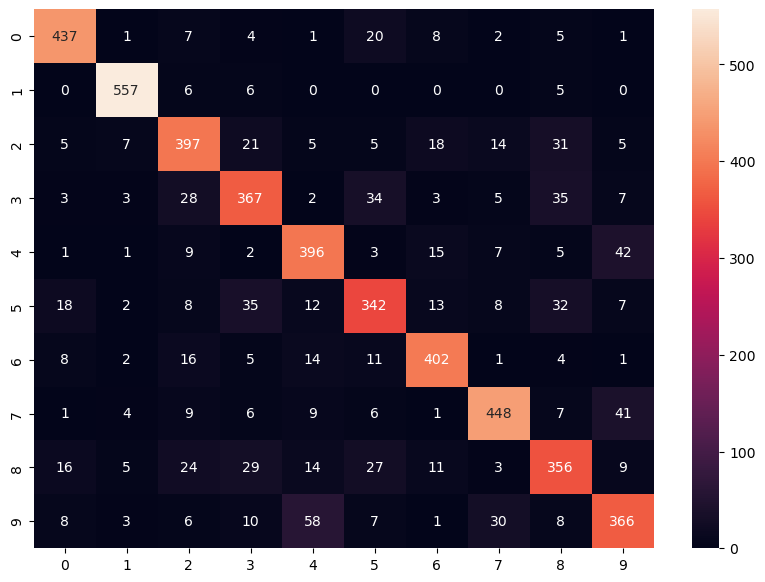

Test Accuracy: 39.18%


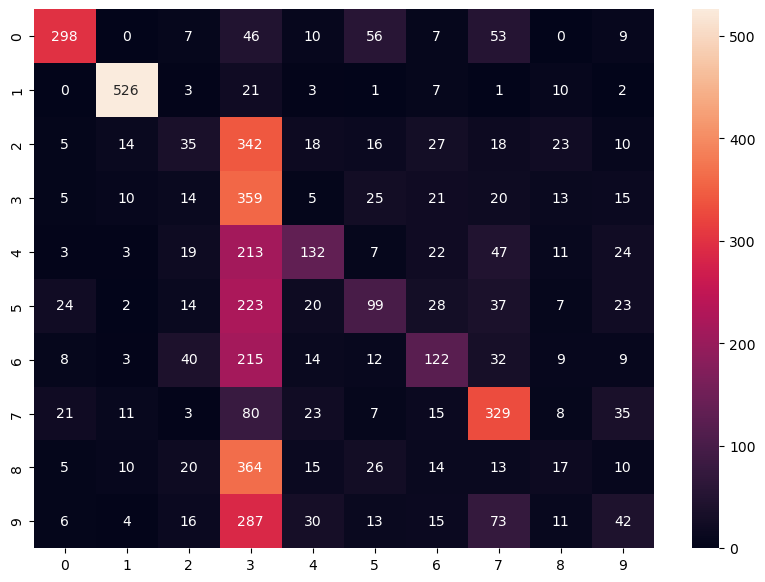

Test Accuracy: 11.48%


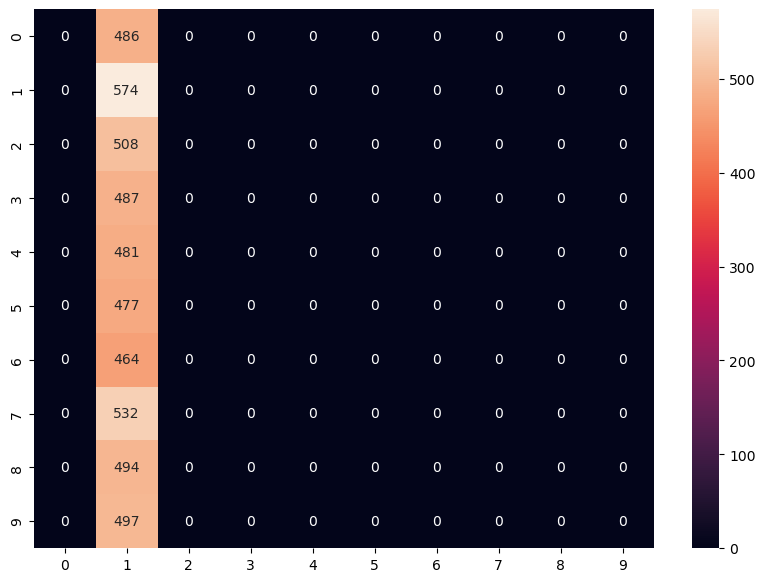

In [5]:

activations = ['Sigmoid', 'ReLU', 'LeakyReLU', 'Tanh']
initializations = ['random', 'normal', 'zero']
models = []
for activation_name in activations:
    for init_type in initializations:
        model_filename = f"model_{activation_name}_{init_type}.pkl"
        with open(model_filename, 'rb') as f:
            models.append(pickle.load(f))


# Train
for model in models:
    predictions = model.predict(X_train)
    y_train_labels = np.argmax(y_train, axis=0)
    accuracy = model.accuracy(y_train_labels, predictions)
    print(f"Train Accuracy: {accuracy * 100:.2f}%")
    cm = confusion_matrix(y_train_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

# Test
for model in models:
    predictions = model.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=0)
    accuracy = model.accuracy(y_test_labels, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    cm = confusion_matrix(y_test_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()



